# Support Vector Machine with SDAE

## 1. Imports

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


**Installing RAPIDS for GPU-accelerated SVM**

In [2]:
!nvidia-smi

Thu Apr 13 05:32:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 385 (delta 86), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (385/385), 105.74 KiB | 252.00 KiB/s, done.
Resolving deltas: 100% (188/188), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.6 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a NVIDIA A100-SXM4-40GB!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import cudf
cudf.__version__

/usr/local/lib/python3.9/dist-packages/rmm/__init__.py:56: FutureWarning: Use of 'rmm.RMMNumbaManager' is deprecated and will be removed. 'RMMNumbaManager' now lives in the 'rmm.allocators.numba' sub-module, please update your imports.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/rmm/__init__.py:56: FutureWarning: Use of 'rmm.rmm_cupy_allocator' is deprecated and will be removed. 'rmm_cupy_allocator' now lives in the 'rmm.allocators.cupy' sub-module, please update your imports.
  warnings.warn(


'23.2.0'

In [5]:
import cuml
cuml.__version__

/usr/local/lib/python3.9/dist-packages/rmm/__init__.py:56: FutureWarning: Use of 'rmm.rmm_cupy_allocator' is deprecated and will be removed. 'rmm_cupy_allocator' now lives in the 'rmm.allocators.cupy' sub-module, please update your imports.
  warnings.warn(


'23.2.0'

In [6]:
import cugraph
cugraph.__version__

'23.2.0'

In [7]:
import os
import numpy as np
import pandas as pd

# Classifier
from cuml.svm import LinearSVC

# Character N-gram feature extractor
from sklearn.feature_extraction.text import CountVectorizer

# Util
from data_io import get_book
import torch
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

# Keras 
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam

# Plotting
import matplotlib.pyplot as plt

import tensorflow as tf

## 2. Create the training, test and validation sets

In [8]:
train_data = pd.concat(pd.read_csv("train.csv", chunksize = 100))
test_data = pd.concat(pd.read_csv("test.csv", chunksize = 100))
val_data = pd.concat(pd.read_csv("val.csv", chunksize = 100))

cv = CountVectorizer(analyzer='char', ngram_range=(1, 5), dtype=np.float32, max_features=10000)
X_train, X_test, X_val = cv.fit_transform(train_data.text.tolist()), cv.transform(test_data.text.tolist()), cv.transform(val_data.text.tolist())  
Y_train, Y_test, Y_val = train_data.author.tolist(), test_data.author.tolist(), val_data.author.tolist()

**Convert labelled data into numbers**

In [9]:
Encoder = LabelEncoder()
Y_train = Encoder.fit_transform(Y_train)
Y_test = Encoder.transform(Y_test)
Y_val = Encoder.transform(Y_val)

print(np.array(Y_train))

[ 4 26 25 ...  4 24 16]


**Distribution of Training Data**

In [10]:
print(X_train.shape)
# print(cv.vocabulary_)
print(len(train_data.text.tolist()[1].split(" ")))

one_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 1]
print("total occurrences of length 1 char n-gram")
print(sum(one_ngram_occurrences))
print("total amount of length 1 char n-gram")
print(len(one_ngram_occurrences))

two_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 2]
print("total occurrences of length 2 char n-gram")
print(sum(two_ngram_occurrences))
print("total amount of length 2 char n-gram")
print(len(two_ngram_occurrences))

three_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 3]
print("total occurrences of length 3 char n-gram")
print(sum(three_ngram_occurrences))
print("total amount of length 3 char n-gram")
print(len(three_ngram_occurrences))

four_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 4]
print("total occurrences of length 4 char n-gram")
print(sum(four_ngram_occurrences))
print("total amount of length 4 char n-gram")
print(len(four_ngram_occurrences))

five_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 5]
print("total occurrences of length 5 char n-gram")
print(sum(five_ngram_occurrences))
print("total amount of length 5 char n-gram")
print(len(five_ngram_occurrences))

(48000, 10000)
512
total occurrences of length 1 char n-gram
160718
total amount of length 1 char n-gram
27
total occurrences of length 2 char n-gram
2214653
total amount of length 2 char n-gram
392
total occurrences of length 3 char n-gram
11458080
total amount of length 3 char n-gram
2121
total occurrences of length 4 char n-gram
19616643
total amount of length 4 char n-gram
3914
total occurrences of length 5 char n-gram
16544906
total amount of length 5 char n-gram
3546


**Data Normalization using MinMax Scaler**

In [11]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, X_val = X_train.toarray(), X_test.toarray(), X_val.toarray()

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

print(X_train_scaled)

[[1.0000001  0.592233   0.12121212 ... 0.         0.         0.        ]
 [1.0000001  0.5436893  0.13636364 ... 0.         0.         0.        ]
 [1.0000001  0.4563107  0.1969697  ... 0.16666667 0.16666667 0.        ]
 ...
 [1.0000001  0.631068   0.22727273 ... 0.         0.         0.        ]
 [1.0000001  0.46601942 0.13636364 ... 0.         0.         0.        ]
 [1.0000001  0.5339806  0.12121212 ... 0.         0.         0.        ]]


## 3. SVM without SDAE

In [12]:
model_names = ['Raw SVM', '1-layer SDAE SVM', '2-layers SDAE SVM', '3-layers SDAE SVM']
predicted_arr = []

In [13]:
svm = LinearSVC(C=1.0, probability=True)
svm.fit(X_train_scaled, Y_train)
preds = svm.predict(X_test_scaled)

print("SVM Accuracy Score on test -> ", metrics.accuracy_score(preds, Y_test)*100)
print("SVM Accuracy Score on training -> ", metrics.accuracy_score(svm.predict(X_train_scaled), Y_train)*100)
print("SVM Accuracy Score on validation -> ", metrics.accuracy_score(svm.predict(X_val_scaled), Y_val)*100)

predicted_arr.append(preds)

SVM Accuracy Score on test ->  92.9
SVM Accuracy Score on training ->  99.96875
SVM Accuracy Score on validation ->  92.71666666666667


## 4. SVM with SDAE

### 4.1 Class for tying weights in a denoising auto encoder

In [14]:
# Code referenced from https://medium.com/@lmayrandprovencher/building-an-autoencoder-with-tied-weights-in-keras-c4a559c529a2

class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
  
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

### 4.2 Class for construction of a denoising autoencoder

In [15]:
np.random.seed(55)
class DenoisingAutoEncoder:
    def __init__(self, layers, corruption, activate_encoder, activate_decoder):
        self.layers = layers
        self.corruption = corruption
        self.activate_encoder = activate_encoder
        self.activate_decoder = activate_decoder
        self.history = None
  
    def forward(self, X_train, X_val, epochs, batch_size):
        # Step 1, Add binomial noise
        X_train_noisy = self.inject_noise(X_train)

        # Step 2, Encode X_train_noisy using sigmoid
        encoder_input = Input(shape = (X_train_noisy.shape[1], ))
        encoder = Dense(self.layers[0], activation=self.activate_encoder)
        final_encoder = encoder(encoder_input)

        # Step 3, Decode X_train_noisy using sigmoid
        # Tie the weights between the encoder and decoder layers
        decoder = DenseTranspose(encoder, activation=self.activate_decoder)
        final_decoder = decoder(final_encoder)

        # Step 4, cross entropy loss for normalised data and adam optimizer (Not sure what optimizer the paper uses)
        autoencoder = Model(encoder_input, final_decoder)
        autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

        # Train it
        self.history = autoencoder.fit(X_train_noisy, X_train, batch_size = batch_size, epochs = epochs, validation_data=(X_val, X_val))
        autoencoder.summary()

        # Get the model that maps input to its encoded representation
        encoder_model = Model(encoder_input, final_encoder)

        # Return the (encoding model, encoding function)
        return (encoder_model, encoder)

    def inject_noise(self, x):
        # inject binomial noise since this model assumes you are normalising input 
        # with min max normalisation
        mask = np.random.choice([0, 1], size=x.shape, p=[self.corruption, 1-self.corruption])
        X_noisy = x * mask
        return X_noisy

### 4.3 Class for construction of a stacked denoising autoencoder

In [16]:
# For picking the best model while fine-tuning
from tensorflow.keras.callbacks import ModelCheckpoint

In [17]:
class StackedDenoisingAutoEncoder():
    def __init__(self, layers, corruption, activate_encoder, activate_decoder):
        self.layers = layers
        self.corruption = corruption
        self.activate_encoder = activate_encoder
        self.activate_decoder = activate_decoder
        self.encoding_funcs = []
        self.encoder_layers = []
        self.history = None
  
    def pretrain(self, X_train, X_val, epochs, batch_size):
        # self.layers contains the units each denoising autoencoder should take in
        learnt_input = X_train
        encoded_validation = X_val
        for layer in self.layers:
            autoencoder = DenoisingAutoEncoder([layer], self.corruption, self.activate_encoder, self.activate_decoder)
            (encoding_function, encoder) = autoencoder.forward(learnt_input, encoded_validation, epochs, batch_size)
            learnt_input = encoding_function.predict(learnt_input)
            encoded_validation = encoding_function.predict(encoded_validation)

            self.encoding_funcs.append(encoding_function)
            self.encoder_layers.append(encoder)

        self.history = autoencoder.history

    def finetune(self, X_train, Y_train, X_val, Y_val, epochs, batch_size):
        encoder_input = Input(shape = (X_train.shape[1], ))

        final_encoder = encoder_input
        for encoder in self.encoder_layers:
            final_encoder = encoder(final_encoder)

        # Define the logistic regression layer
        lr_layer = Dense(Y_train.shape[1], activation='softmax')
        predictions = lr_layer(final_encoder)

        # Create the fine-tuned model
        fine_tuned_model = Model(inputs=encoder_input, outputs=predictions)
        fine_tuned_model.compile(loss='categorical_crossentropy', optimizer='adam')

        # Select best model
        checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
        self.history = fine_tuned_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), callbacks=[checkpointer])
        fine_tuned_model.load_weights('weights.hdf5')

        fine_tuned_encoder = Model(inputs=encoder_input, outputs=final_encoder)
        return (fine_tuned_model, fine_tuned_encoder)

    def encode(self, X):
        encoded_representation = X
        for func in self.encoder_layers:
            encoded_representation = func.predict(encoded_representation)
        return encoded_representation

## 5. Pretraining and Finetuning

**Pretrain the denoising autoencoder**

In [53]:
# The "stacked" auto encoder will only contain 1 denoising auto encoder that will 
# transform the original input into 1000 units. Noise corruption is 0.3 and it uses 
# sigmoid activation for both encoder and decoder
stacked_auto_encoder_1 = StackedDenoisingAutoEncoder([1000], 0.3, 'sigmoid', 'sigmoid')
stacked_auto_encoder_1.pretrain(X_train_scaled, X_val_scaled, 20, 128)

Epoch 1/20
375/375 [==============================] - 3s 6ms/step - loss: 0.2193 - val_loss: 0.2237
Epoch 2/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1822 - val_loss: 0.1964
Epoch 3/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1659 - val_loss: 0.1748
Epoch 4/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1590 - val_loss: 0.1662
Epoch 5/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1554 - val_loss: 0.1622
Epoch 6/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1526 - val_loss: 0.1598
Epoch 7/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1502 - val_loss: 0.1577
Epoch 8/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1483 - val_loss: 0.1559
Epoch 9/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1468 - val_loss: 0.1545
Epoch 10/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1455 - val_loss: 0.1532

In [54]:
# The "stacked" auto encoder will have 2 DAE's stacked, each with 1000 units.
stacked_auto_encoder_2 = StackedDenoisingAutoEncoder([1000, 1000], 0.3, 'sigmoid', 'sigmoid')
stacked_auto_encoder_2.pretrain(X_train_scaled, X_val_scaled, 20, 128)

Epoch 1/20
375/375 [==============================] - 3s 6ms/step - loss: 0.2192 - val_loss: 0.2246
Epoch 2/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1822 - val_loss: 0.1966
Epoch 3/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1658 - val_loss: 0.1758
Epoch 4/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1589 - val_loss: 0.1659
Epoch 5/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1554 - val_loss: 0.1624
Epoch 6/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1526 - val_loss: 0.1596
Epoch 7/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1502 - val_loss: 0.1578
Epoch 8/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1483 - val_loss: 0.1561
Epoch 9/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1468 - val_loss: 0.1545
Epoch 10/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1455 - val_loss: 0.1531

In [55]:
# The "stacked" auto encoder will have 3 DAE's stacked, each with 1000 units.
stacked_auto_encoder_3 = StackedDenoisingAutoEncoder([1000, 1000, 1000], 0.3, 'sigmoid', 'sigmoid')
stacked_auto_encoder_3.pretrain(X_train_scaled, X_val_scaled, 20, 128)

Epoch 1/20
375/375 [==============================] - 3s 6ms/step - loss: 0.2192 - val_loss: 0.2258
Epoch 2/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1822 - val_loss: 0.1975
Epoch 3/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1659 - val_loss: 0.1748
Epoch 4/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1589 - val_loss: 0.1659
Epoch 5/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1554 - val_loss: 0.1626
Epoch 6/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1526 - val_loss: 0.1599
Epoch 7/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1502 - val_loss: 0.1577
Epoch 8/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1483 - val_loss: 0.1559
Epoch 9/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1468 - val_loss: 0.1545
Epoch 10/20
375/375 [==============================] - 2s 5ms/step - loss: 0.1455 - val_loss: 0.1531

### SDAE Pretraining Plot

In [56]:
def plot_loss(history):
    # summarize history for loss
    # https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

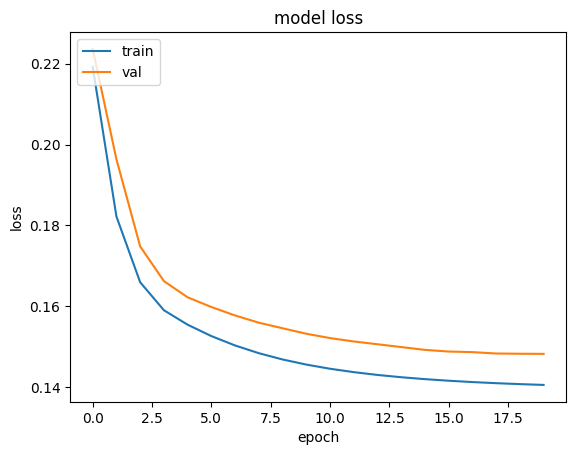

In [57]:
plot_loss(stacked_auto_encoder_1.history.history)

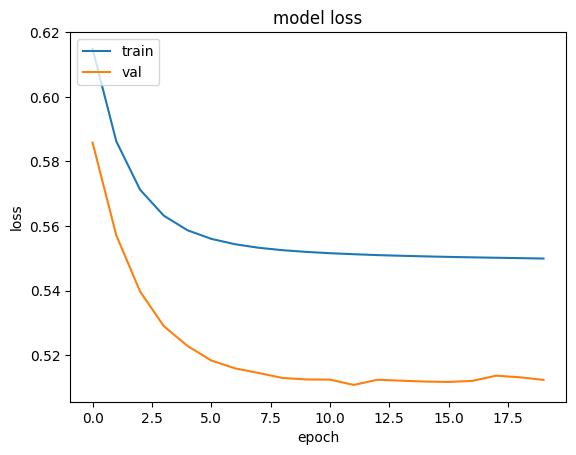

In [58]:
plot_loss(stacked_auto_encoder_2.history.history)

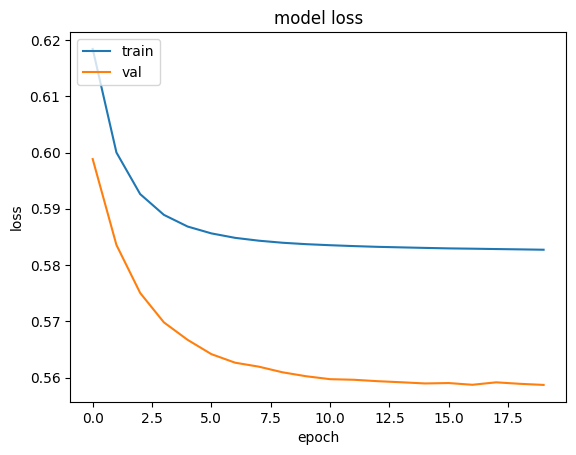

In [59]:
plot_loss(stacked_auto_encoder_3.history.history)

**Finetune the model by adding logistic regression layer**

In [60]:
# Create a 1 hot encoded Y_train
def create_one_hot(arr):
    out_arr = []
    for item in arr:
        max_arr = max(arr)
        one_hot_encoded = [0] * (max_arr+1)
        one_hot_encoded[item] = 1
        out_arr.append(one_hot_encoded)
    return np.array(out_arr)

Y_train_hot_encoded = create_one_hot(Y_train)
Y_val_hot_encoded = create_one_hot(Y_val)

In [61]:
fine_tuned_model_1, fine_tuned_encoder_1 = stacked_auto_encoder_1.finetune(X_train_scaled, Y_train_hot_encoded, X_val_scaled, Y_val_hot_encoded, 30, 128) 

Epoch 1/30
375/375 [==============================] - ETA: 0s - loss: 1.1841
Epoch 1: val_loss improved from inf to 0.50484, saving model to weights.hdf5
375/375 [==============================] - 3s 5ms/step - loss: 1.1841 - val_loss: 0.5048
Epoch 2/30
361/375 [===========================>..] - ETA: 0s - loss: 0.2969
Epoch 2: val_loss improved from 0.50484 to 0.33784, saving model to weights.hdf5
375/375 [==============================] - 2s 5ms/step - loss: 0.2945 - val_loss: 0.3378
Epoch 3/30
362/375 [===========================>..] - ETA: 0s - loss: 0.1323
Epoch 3: val_loss improved from 0.33784 to 0.30240, saving model to weights.hdf5
375/375 [==============================] - 2s 5ms/step - loss: 0.1321 - val_loss: 0.3024
Epoch 4/30
363/375 [============================>.] - ETA: 0s - loss: 0.0615
Epoch 4: val_loss improved from 0.30240 to 0.26289, saving model to weights.hdf5
375/375 [==============================] - 2s 5ms/step - loss: 0.0615 - val_loss: 0.2629
Epoch 5/30
371/3

In [62]:
fine_tuned_model_2, fine_tuned_encoder_2 = stacked_auto_encoder_2.finetune(X_train_scaled, Y_train_hot_encoded, X_val_scaled, Y_val_hot_encoded, 30, 128)

Epoch 1/30
370/375 [============================>.] - ETA: 0s - loss: 1.0498
Epoch 1: val_loss improved from inf to 0.45888, saving model to weights.hdf5
375/375 [==============================] - 3s 6ms/step - loss: 1.0411 - val_loss: 0.4589
Epoch 2/30
369/375 [============================>.] - ETA: 0s - loss: 0.2238
Epoch 2: val_loss improved from 0.45888 to 0.33889, saving model to weights.hdf5
375/375 [==============================] - 2s 5ms/step - loss: 0.2240 - val_loss: 0.3389
Epoch 3/30
370/375 [============================>.] - ETA: 0s - loss: 0.0774
Epoch 3: val_loss improved from 0.33889 to 0.28053, saving model to weights.hdf5
375/375 [==============================] - 2s 5ms/step - loss: 0.0776 - val_loss: 0.2805
Epoch 4/30
373/375 [============================>.] - ETA: 0s - loss: 0.0264
Epoch 4: val_loss improved from 0.28053 to 0.26384, saving model to weights.hdf5
375/375 [==============================] - 2s 5ms/step - loss: 0.0264 - val_loss: 0.2638
Epoch 5/30
368/3

In [63]:
fine_tuned_model_3, fine_tuned_encoder_3 = stacked_auto_encoder_3.finetune(X_train_scaled, Y_train_hot_encoded, X_val_scaled, Y_val_hot_encoded, 30, 128) 

Epoch 1/30
369/375 [============================>.] - ETA: 0s - loss: 1.0070
Epoch 1: val_loss improved from inf to 0.42204, saving model to weights.hdf5
375/375 [==============================] - 4s 6ms/step - loss: 0.9980 - val_loss: 0.4220
Epoch 2/30
363/375 [============================>.] - ETA: 0s - loss: 0.2125
Epoch 2: val_loss improved from 0.42204 to 0.33588, saving model to weights.hdf5
375/375 [==============================] - 2s 5ms/step - loss: 0.2120 - val_loss: 0.3359
Epoch 3/30
366/375 [============================>.] - ETA: 0s - loss: 0.0707
Epoch 3: val_loss improved from 0.33588 to 0.29725, saving model to weights.hdf5
375/375 [==============================] - 2s 5ms/step - loss: 0.0704 - val_loss: 0.2973
Epoch 4/30
371/375 [============================>.] - ETA: 0s - loss: 0.0236
Epoch 4: val_loss improved from 0.29725 to 0.27480, saving model to weights.hdf5
375/375 [==============================] - 2s 5ms/step - loss: 0.0237 - val_loss: 0.2748
Epoch 5/30
367/3

### Plot of Finetuning Training

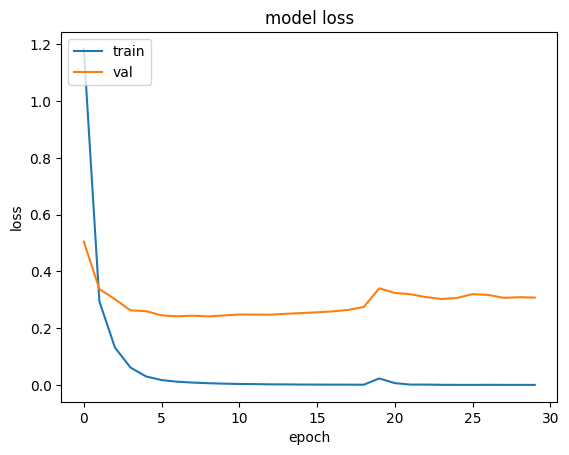

In [64]:
plot_loss(stacked_auto_encoder_1.history.history)

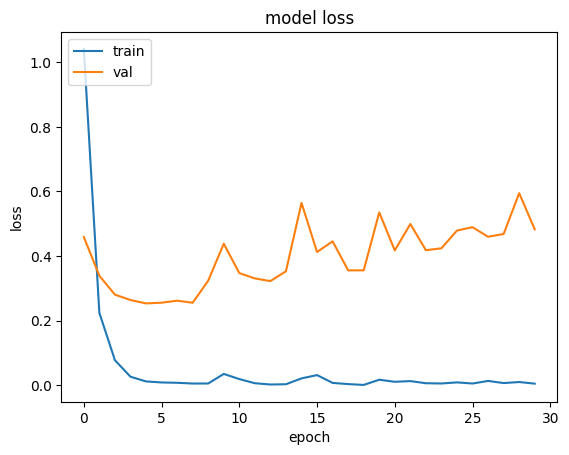

In [65]:
plot_loss(stacked_auto_encoder_2.history.history)

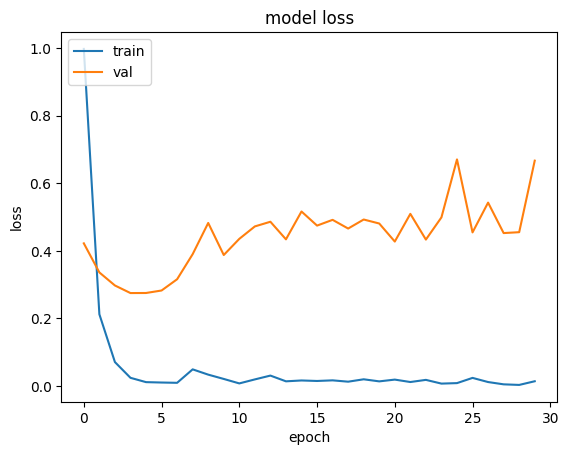

In [66]:
plot_loss(stacked_auto_encoder_3.history.history)

**Now feed the encoded representation into linear SVM**

In [81]:
fine_tuned_encoders = [fine_tuned_encoder_1, fine_tuned_encoder_2, fine_tuned_encoder_3]
svms = []
for fine_tuned_encoder, model_name in zip(fine_tuned_encoders, model_names[1:]):
    print(model_name)
    X_train_encoded = fine_tuned_encoder.predict(X_train_scaled)

    # Fit to encoded data
    svm_autoencoder = LinearSVC(C=1.0, probability=True)
    svm_autoencoder.fit(X_train_encoded, Y_train)

    # Encode the test data and use SVM to predict its labels
    X_test_encoded = fine_tuned_encoder.predict(X_test_scaled)
    predicted = svm_autoencoder.predict(X_test_encoded)

    print("SVM Accuracy Score -> ", metrics.accuracy_score(predicted, Y_test)*100)
    predicted_arr.append(predicted)
    
    predicted_train = svm_autoencoder.predict(X_train_encoded)
    print("SVM Accuracy Score on training -> ", metrics.accuracy_score(predicted_train, Y_train)*100)

    X_val_encoded = fine_tuned_encoder.predict(X_val_scaled)
    predicted_val = svm_autoencoder.predict(X_val_encoded)
    print("SVM Accuracy Score on validation -> ", metrics.accuracy_score(predicted_val, Y_val)*100)

    svms.append(svm_autoencoder)

1-layer SDAE SVM
188/188 [==============================] - 0s 1ms/step
SVM Accuracy Score ->  92.0
SVM Accuracy Score on training ->  99.98541666666667
188/188 [==============================] - 0s 1ms/step
SVM Accuracy Score on validation ->  92.08333333333333
2-layers SDAE SVM
188/188 [==============================] - 0s 2ms/step
SVM Accuracy Score ->  93.45
SVM Accuracy Score on training ->  99.99583333333332
188/188 [==============================] - 0s 2ms/step
SVM Accuracy Score on validation ->  93.01666666666667
3-layers SDAE SVM
188/188 [==============================] - 0s 2ms/step
SVM Accuracy Score ->  93.0
SVM Accuracy Score on training ->  99.97500000000001
188/188 [==============================] - 0s 2ms/step
SVM Accuracy Score on validation ->  93.08333333333333


## 6. Testing metrics

In [82]:
def testing_metrics(y_true, y_pred_arr, model_names, export=True):
    stats = {}
    for y_pred, model_name in zip(y_pred_arr, model_names):
        scores = metrics.classification_report(y_true, y_pred, zero_division=1, output_dict=True)

        stats[model_name] = {
            'cohen_kappa': metrics.cohen_kappa_score(y_true, y_pred),
            'matthews_corrcoef': metrics.matthews_corrcoef(y_true, y_pred),
            'micro-accuracy': scores['accuracy']
        }

        for metr1 in ('macro avg', 'weighted avg'):
            for metr2 in ('precision', 'recall', 'f1-score'):
                stats[model_name][metr1 + ' ' + metr2] = scores[metr1][metr2]
    
    stats_df = pd.DataFrame.from_dict(stats).T
    if export:
        stats_df.to_csv('svm_stats.csv')
    
    return stats_df

In [83]:
testing_metrics(Y_test, predicted_arr, model_names)

,cohen_kappa,matthews_corrcoef,micro-accuracy,macro avg precision,macro avg recall,macro avg f1-score,weighted avg precision,weighted avg recall,weighted avg f1-score
Raw SVM,0.926552,0.926564,0.929000,0.929046,0.929000,0.928849,0.929046,0.929000,0.928849
1-layer SDAE SVM,0.920172,0.920192,0.922833,0.922889,0.922833,0.922583,0.922889,0.922833,0.922583
2-layers SDAE SVM,0.931207,0.931230,0.933500,0.933783,0.933500,0.933304,0.933783,0.933500,0.933304
3-layers SDAE SVM,0.926552,0.926573,0.929000,0.929107,0.929000,0.928746,0.929107,0.929000,0.928746
